# A simple demonstration of coregionalisation

This notebook shows how to construct a multi-output GP model using GPflow. We will consider a regression problem for functions $f: \mathbb{R}^D \rightarrow \mathbb{R}^P$. We assume that the dataset is of the form $(X_1, f_1), \dots, (X_P, f_P)$, that is, we do not necessarily observe all the outputs for a particular input location (for cases where there are fully observed outputs for each input, see [Multi-output Gaussian processes in GPflow](./multioutput.ipynb) for a more efficient implementation).

For this problem, we model $f$ as a *coregionalised* Gaussian process, which assumes a kernel of the form:

$$\textrm{cov}(f_i(X), f_j(X^\prime)) = k(X, X^\prime) \cdot B[i, j].$$

The covariance of the $i$th function at $X$ and the $j$th function at $X^\prime$ is a kernel applied at $X$ and $X^\prime$, times the $(i, j)$th entry of a positive definite $P \times P$ matrix $B$. This is known as the **intrinsic model of coregionalisation (ICM)** (Bonilla and Williams, 2008).

To make sure that B is positive-definite, we parameterise it as:

$$B = W W^\top + \textrm{diag}(\kappa).$$

To build such a model in GPflow, we need to perform the following two steps:

 * Create the kernel function defined previously, using the `Coregion` kernel class.
 * Augment the training data X with an extra column that contains an integer index to indicate which output an observation is associated with. This is essential to make the data work with the `Coregion` kernel.

In [1]:
import gpflow
import tensorflow as tf
import numpy as np
import matplotlib
%matplotlib inline

from gpflow.ci_utils import ci_niter

matplotlib.rcParams['figure.figsize'] = (12, 6)
plt = matplotlib.pyplot
np.random.seed(123)

## Data preparation
We start by generating some training data to fit the model with. For this example, we choose the following two correlated functions for our outputs:
$$
\begin{align}
y_1 &= \sin(6x) + \epsilon_1, \qquad \epsilon_1 \sim \mathcal{N}(0, 0.009) \\
y_2 &= \sin(6x + 0.7) + \epsilon_2, \qquad \epsilon_2 \sim \mathcal{N}(0, 0.01) \\
\end{align}
$$

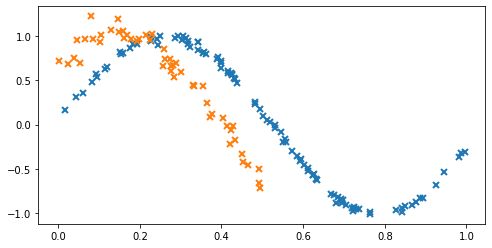

In [2]:
# make a dataset with two outputs, correlated, heavy-tail noise. One has more noise than the other.
X1 = np.random.rand(100, 1) # Observed locations for first output
X2 = np.random.rand(50, 1) * 0.5 # Observed locations for second output

Y1 = np.sin(6*X1) + np.random.randn(*X1.shape) * 0.03
Y2 = np.sin(6*X2+ 0.7) + np.random.randn(*X2.shape) * 0.1

plt.figure(figsize=(8, 4))
plt.plot(X1, Y1, 'x', mew=2)
plt.plot(X2, Y2, 'x', mew=2);

## Data formatting for the coregionalised model
We add an extra column to our training dataset that contains an index that specifies which output is observed.

In [3]:
# Augment the input with ones or zeros to indicate the required output dimension
X_augmented = np.vstack((np.hstack((X1, np.zeros_like(X1))), np.hstack((X2, np.ones_like(X2)))))

# Augment the Y data
Y_augmented = np.vstack((np.hstack((Y1, np.zeros_like(Y1))), np.hstack((Y2, np.ones_like(Y2)))))

## Building the coregionalisation kernel
We build a coregionalisation kernel with the Matern 3/2 kernel as the base kernel. This acts on the leading ([0]) data dimension of the augmented X values. The `Coregion` kernel indexes the outputs, and acts on the last ([1]) data dimension (indices) of the augmented X values. To specify these dimensions, we use the built-in `active_dims` argument in the kernel constructor. To construct the full multi-output kernel, we take the product of the two kernels (for a more in-depth tutorial on kernel combination, see [Manipulating kernels](./kernels.ipynb)).

In [4]:
output_dim = 2 # Number of outputs
rank = 1 # Rank of W

# Base kernel
k = gpflow.kernels.Matern32(active_dims=[0])

# Coregion kernel
coreg = gpflow.kernels.Coregion(output_dim=output_dim, rank=rank, active_dims=[1])
coreg.W.assign(np.random.rand(output_dim, rank))  # Initialise the W matrix to break symmetry

kern = k * coreg

**Note:** By default, the `W` matrix is initialised with zeros; however, this is a saddle point in the objective, so the value of `W` is not optimised to fit the data. Hence, re-initialising the matrix to random entries should give a more accurate result.

## Constructing the model
The final element in building the model is to specify the likelihood for each output dimension. To do this, use the `SwitchedLikelihood` object in GPflow.

In [5]:
# This likelihood switches between Gaussian noise with different variances for each f_i:
lik = gpflow.likelihoods.SwitchedLikelihood([gpflow.likelihoods.Gaussian(), gpflow.likelihoods.Gaussian()])

# now build the GP model as normal
m = gpflow.models.VGP((X_augmented, Y_augmented), kernel=kern, likelihood=lik, num_latent=1)
# Here we specify num_latent=1 to avoid getting two outputs when predicting as Y_augmented is 2-dimensional

# closure
@tf.function
def objective_closure():
    return m.neg_log_marginal_likelihood()

# fit the covariance function parameters
maxiter = ci_niter(10000)
gpflow.optimizers.Scipy().minimize(objective_closure, m.trainable_variables, options=dict(maxiter=maxiter),
                                   method='CG')

     fun: -225.66207811383714
     jac: array([-2.74560257e-04, -7.95508832e-04,  3.79446712e-04, ...,
        1.44799486e-10,  1.96179766e-10, -1.33157968e-05])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 16143
     nit: 9688
    njev: 16131
  status: 2
 success: False
       x: array([ 7.58722180e-02, -1.80496843e-01, -1.20603819e+00, ...,
        3.65750475e-11, -4.36186486e-11,  4.48960536e-01])

That's it: the model is trained. Let's plot the model fit to see what's happened.

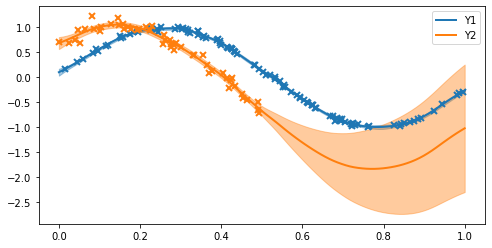

In [6]:
def plot_gp(x, mu, var, color, label):
    plt.plot(x, mu, color=color, lw=2, label=label)
    plt.fill_between(x[:, 0], 
                     (mu - 2*np.sqrt(var))[:, 0], 
                     (mu + 2*np.sqrt(var))[:, 0], 
                     color=color, alpha=0.4)

def plot(m):
    plt.figure(figsize=(8, 4))
    xtest = np.linspace(0, 1, 100)[:,None]
    line, = plt.plot(X1, Y1, 'x', mew=2)
    mu, var = m.predict_f(np.hstack((xtest, np.zeros_like(xtest))))
    plot_gp(xtest, mu, var, line.get_color(), 'Y1')

    line, = plt.plot(X2, Y2, 'x', mew=2)
    mu, var = m.predict_f(np.hstack((xtest, np.ones_like(xtest))))
    plot_gp(xtest, mu, var, line.get_color(), 'Y2')
    
    plt.legend()

plot(m)

From the plots, we can see:

 - The first function (blue) has low posterior variance everywhere because there are so many observations, and the noise variance is small. 
 - The second function (orange) has higher posterior variance near the data, because the data are more noisy, and very high posterior variance where there are no observations (x > 0.5). 
 - The model has done a reasonable job of estimating the noise variance and lengthscales.
 - The model recognises the correlation between the two functions and is able to suggest (with uncertainty) that because x > 0.5 the orange curve should follow the blue curve (which we know to be the truth from the data-generating procedure).
 
The covariance matrix between outputs is as follows:

B = [[2.02990865 1.88623512]
 [1.88623512 3.15832832]]


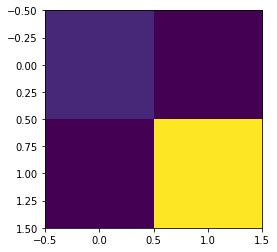

In [7]:
B = coreg.W.numpy() @ coreg.W.numpy().T + np.diag(coreg.kappa.numpy())
print('B =', B)
plt.imshow(B);

## References

Bonilla, Edwin V., Kian M. Chai, and Christopher Williams. "Multi-task Gaussian process prediction." _Advances in neural information processing systems_. 2008.